#  Predicting flight delays

> - 😀 Name: **Martin Tefra**
> - ✉️ Email: **martin.tefra@epfl.ch**

The data of this notebook can be found on this website: https://www.kaggle.com/code/fabiendaniel/predicting-flight-delays-tutorial/input

## Setup

In [1]:
!pip install -r requirements.txt

In [2]:
import torch
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q git+https://github.com/TorchSpatiotemporal/tsl.git

2.2.2


In [3]:
import tsl
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime


# imports for the simple model
import statsmodels.formula.api as smf

# imports for the graph model
# torch-spatiotemporal
from tsl.engines import Predictor
from tsl.data import SpatioTemporalDataset
from tsl.ops.framearray import temporal_mean
from tsl.data.preprocessing import StandardScaler
from tsl.metrics.torch import MaskedMAE, MaskedMAPE
from tsl.data.datamodule import (SpatioTemporalDataModule, TemporalSplitter)

# pytorch_lightning
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# custom class for graph model
from TimeThenSpaceModel import TimeThenSpaceModel

In [4]:
print(f"tsl version  : {tsl.__version__}")
print(f"torch version: {torch.__version__}")

pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(edgeitems=3, precision=3)
torch.set_printoptions(edgeitems=2, precision=3)

# Utility functions ################
def print_matrix(matrix):
    return pd.DataFrame(matrix)

def print_model_size(model):
    tot = sum([p.numel() for p in model.parameters() if p.requires_grad])
    out = f"Number of model ({model.__class__.__name__}) parameters:{tot:10d}"
    print("=" * len(out))
    print(out)

tsl version  : 0.9.4
torch version: 2.2.2


## 1. Data exploration

In [5]:
df = pd.read_csv('data/flights.csv')
df_airports = pd.read_csv('data/airports.csv')
df_airlines = pd.read_csv('data/airlines.csv')

/var/folders/07/9l9kqd013xjdlz8_0b2__8xr0000gq/T/ipykernel_69344/4192093832.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/flights.csv')


In [6]:
df.describe(include=object)

,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,CANCELLATION_REASON
count,5819079,5804358,5819079,5819079,89884
unique,14,4897,930,930,4
top,WN,N480HA,ATL,ATL,B
freq,1261855,3768,346836,346904,48851


In [7]:
# Some cleaning

# remove cancelled flights
df = df[df['CANCELLED'] == 0]

# keep only interesting columns
df_flights = df[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_DELAY', 'AIRLINE', 'DISTANCE', 'ARRIVAL_TIME', 'DAY', 'MONTH', 'YEAR']]

df_flights = df_flights.dropna()

# convert arrival time to datetime
def time_format(row):
    hour = int(row['ARRIVAL_TIME'] // 100) % 24
    minute = int(row['ARRIVAL_TIME'] % 100)

    return f"{hour:02d}:{minute:02d}:00"

month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

df_flights['ARRIVAL_DATE_TIME'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + 
                                 df['MONTH'].astype(str) + '-' + 
                                 df['DAY'].astype(str) + ' ' + 
                                 df_flights.apply(time_format, axis=1))

df_flights = df_flights.drop(columns=['ARRIVAL_TIME', 'DAY', 'MONTH'])

df_flights.sort_values(by=['ARRIVAL_DATE_TIME'], inplace=True)
df_flights.head()

,ORIGIN_AIRPORT,DESTINATION_AIRPORT,ARRIVAL_DELAY,AIRLINE,DISTANCE,YEAR,ARRIVAL_DATE_TIME
13542,SEA,LAX,-23.00,AS,954,2015,2015-01-01 00:00:00
8944,PHX,MIA,117.00,AA,1972,2015,2015-01-01 00:00:00
12723,DFW,MCO,25.00,AA,985,2015,2015-01-01 00:00:00
13579,DEN,LAS,63.00,UA,628,2015,2015-01-01 00:01:00
9562,SNA,EWR,-45.00,UA,2434,2015,2015-01-01 00:01:00


In [8]:
# we filter the flights to remove the outliers 

# remove flights with ARRIVAL_DELAY more than 1 hour
df_flights = df_flights[df_flights['ARRIVAL_DELAY'] < 60]
# remove flights with ARRIVAL_DELAY negative
df_flights = df_flights[df_flights['ARRIVAL_DELAY'] > 0]

In [9]:
# some cleaning
df_flights = df_flights.dropna()

# discard flights with airport codes that are not in the airports dataset
df_flights = df_flights[df_flights['ORIGIN_AIRPORT'].isin(df_airports['IATA_CODE'])]
# discard flights with airline codes that are not in the airlines dataset
df_flights = df_flights[df_flights['AIRLINE'].isin(df_airlines['IATA_CODE'])]

df_flights['ORIGIN_AIRPORT'] = pd.Categorical(df_flights['ORIGIN_AIRPORT'])
df_flights['DESTINATION_AIRPORT'] = pd.Categorical(df_flights['DESTINATION_AIRPORT'])
df_flights['AIRLINE'] = pd.Categorical(df_flights['AIRLINE'])

df_flights['ORIGIN_AIRPORT'] = df_flights['ORIGIN_AIRPORT'].cat.codes
df_flights['DESTINATION_AIRPORT'] = df_flights['DESTINATION_AIRPORT'].cat.codes
df_flights['AIRLINE'] = df_flights['AIRLINE'].cat.codes

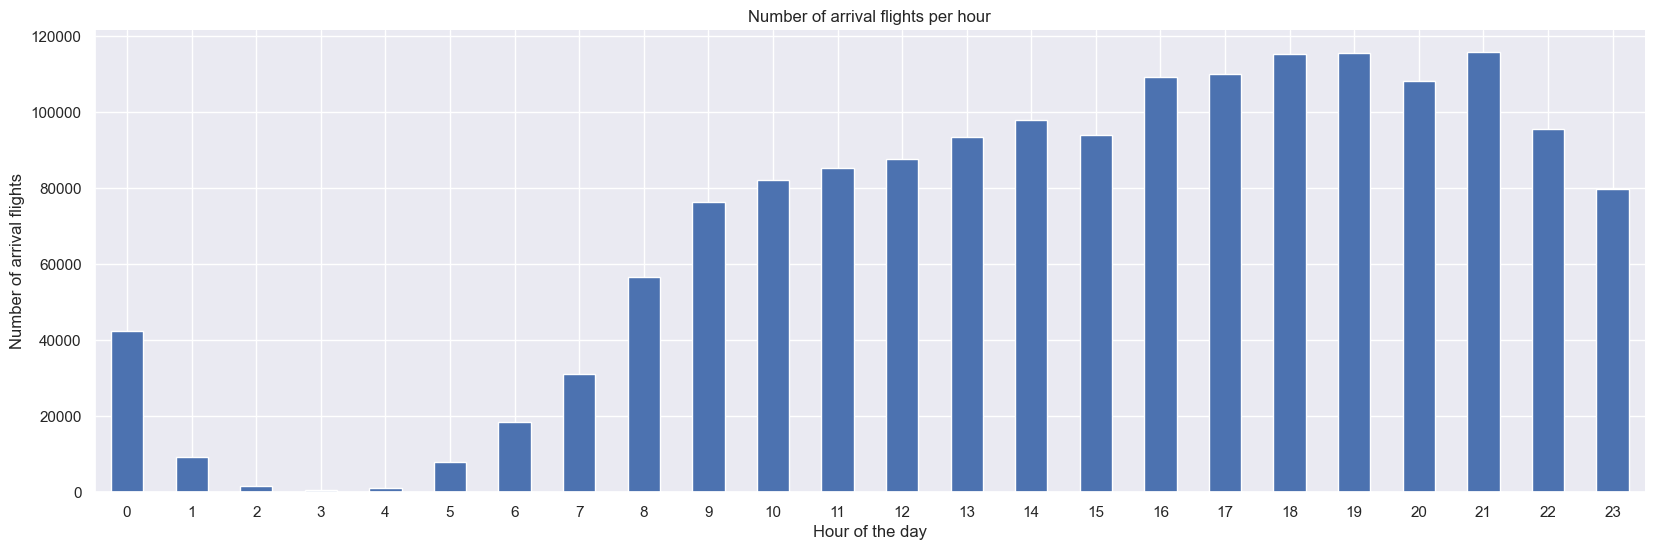

In [10]:
sns.set(rc={'figure.figsize':(20,6)})

# Number of arrivals per hour
df_flights['ARRIVAL_DATE_TIME'].groupby(df_flights.ARRIVAL_DATE_TIME.dt.hour).count().plot(kind="bar")
plt.xticks(rotation=0)
plt.xlabel('Hour of the day')
plt.ylabel('Number of arrival flights')
plt.title("Number of arrival flights per hour")
sns.despine()

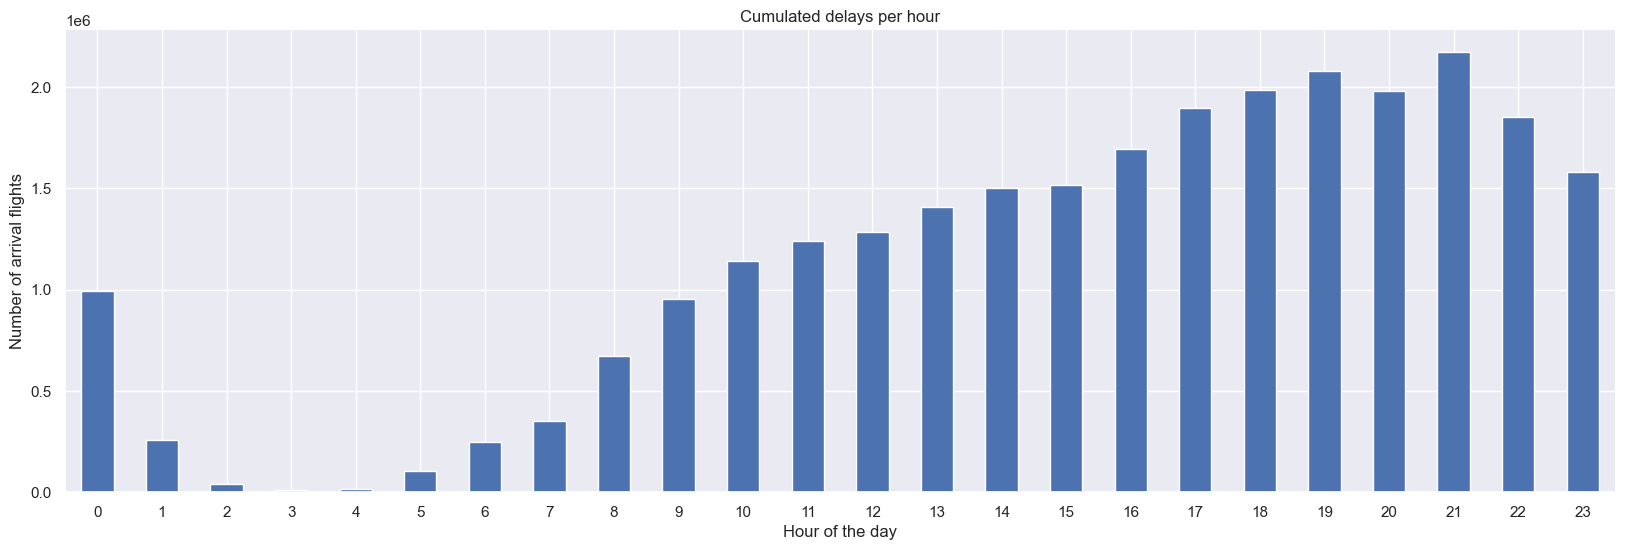

In [11]:
# Cumulated delays per hour
df_flights['ARRIVAL_DELAY'].groupby(df_flights.ARRIVAL_DATE_TIME.dt.hour).sum().plot(kind="bar")
plt.xticks(rotation=0)
plt.xlabel('Hour of the day')
plt.ylabel('Number of arrival flights')
plt.title("Cumulated delays per hour")
sns.despine()

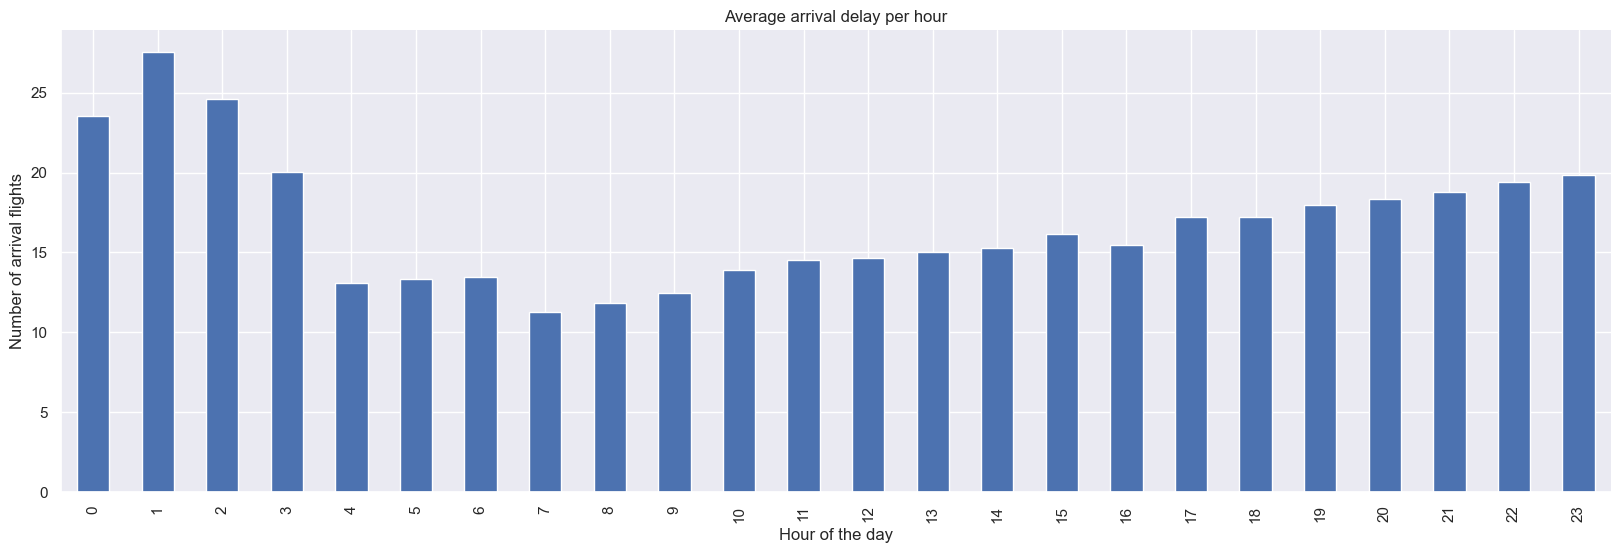

In [12]:
# Average arrival delay per hour
df_flights['ARRIVAL_DELAY'].groupby(df_flights.ARRIVAL_DATE_TIME.dt.hour).mean().plot(kind="bar")
plt.xlabel('Hour of the day')
plt.ylabel('Number of arrival flights')
plt.title("Average arrival delay per hour")
sns.despine()

Delays keep increasing until traffic deacreases during the night.

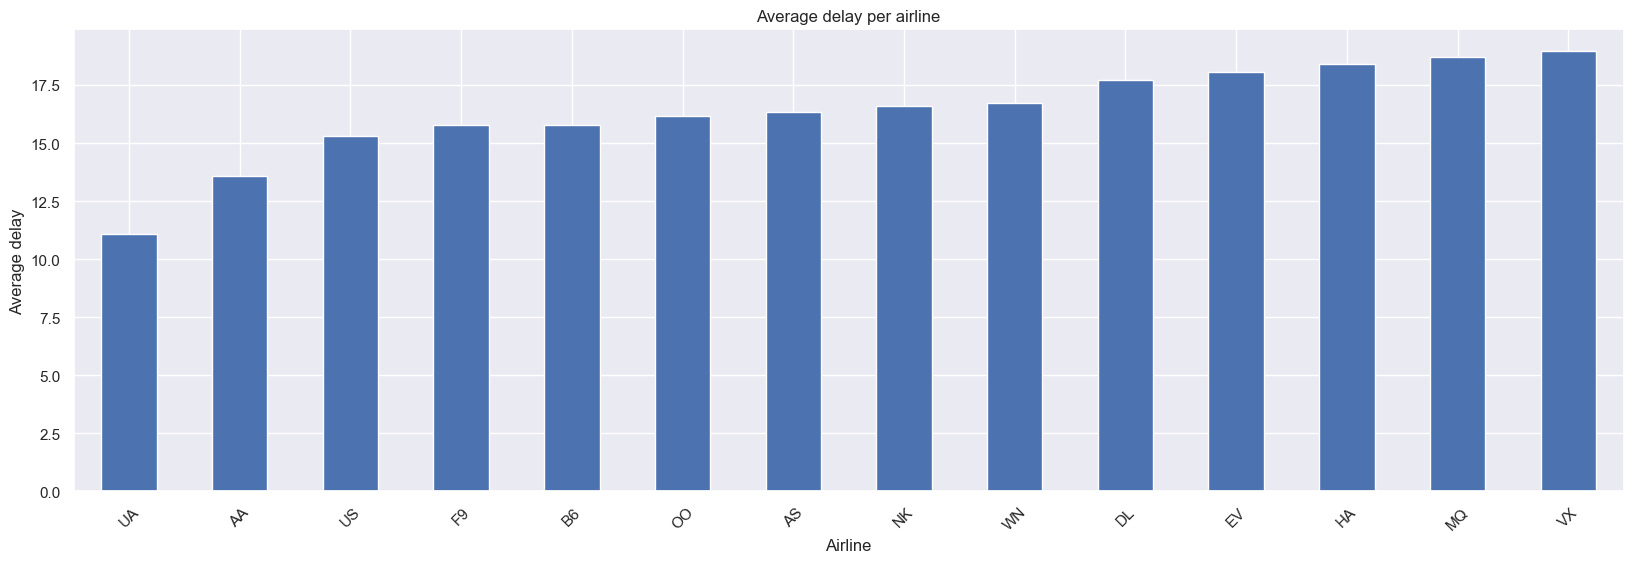

In [13]:
# Average delay per airline
df_flights['ARRIVAL_DELAY'].groupby(df_flights.AIRLINE).mean().sort_values().plot(kind="bar")

# get name of airlines
plt.xticks(np.arange(len(df_airlines)), df_airlines['IATA_CODE'], rotation=45)

plt.xlabel('Airline')
plt.ylabel('Average delay')
plt.title('Average delay per airline')
plt.show()

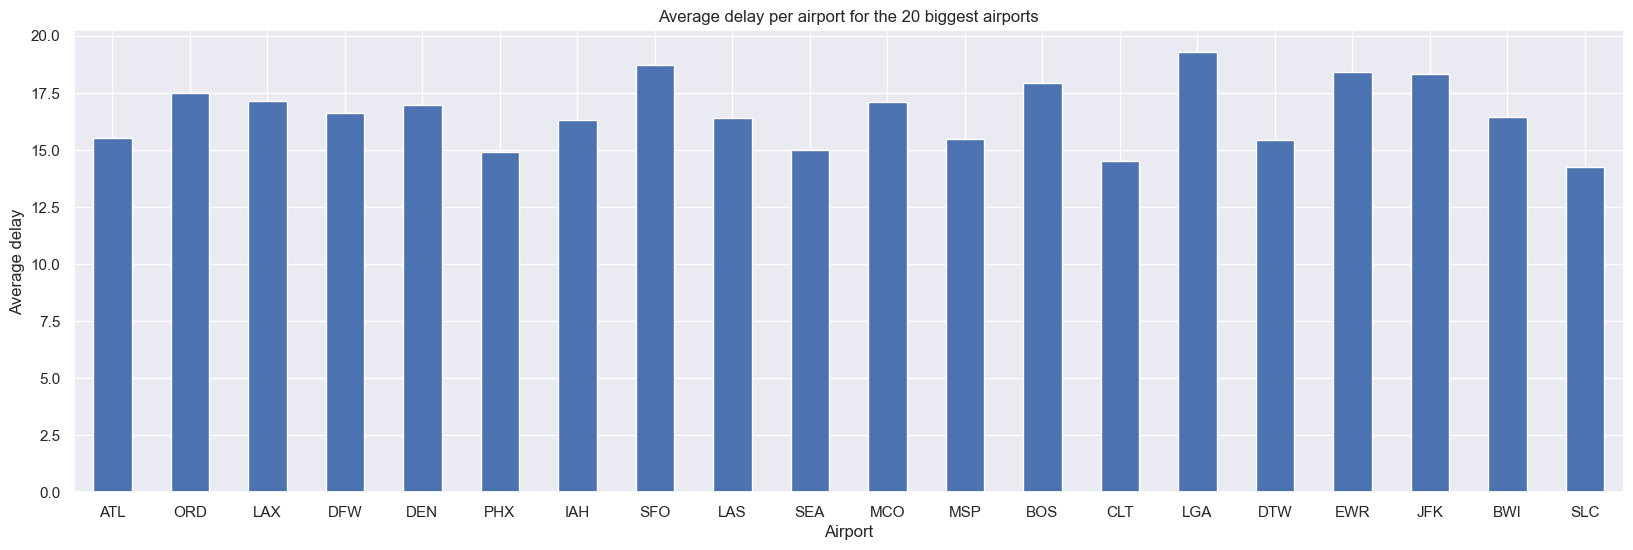

In [14]:
# plot average delay per airport for the 20 biggest airports
biggest_airports = df_flights['DESTINATION_AIRPORT'].value_counts().index[:20]
df_flights['ARRIVAL_DELAY'].groupby(df_flights.DESTINATION_AIRPORT).mean().loc[biggest_airports].plot(kind="bar")

# get the name of the airports
plt.xticks(np.arange(len(biggest_airports)), df_airports['IATA_CODE'][biggest_airports], rotation=0)

plt.xlabel('Airport')
plt.ylabel('Average delay')
plt.title('Average delay per airport for the 20 biggest airports')
plt.show()

Let's now check if there is a pattern in the delay for each airport.

/var/folders/07/9l9kqd013xjdlz8_0b2__8xr0000gq/T/ipykernel_69344/988635325.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  avg_delay_per_hour = df.groupby(['DESTINATION_AIRPORT', df['ARRIVAL_DATE_TIME'].dt.floor('H')])['ARRIVAL_DELAY'].mean().reset_index(name='AVERAGE_ARRIVAL_DELAY')


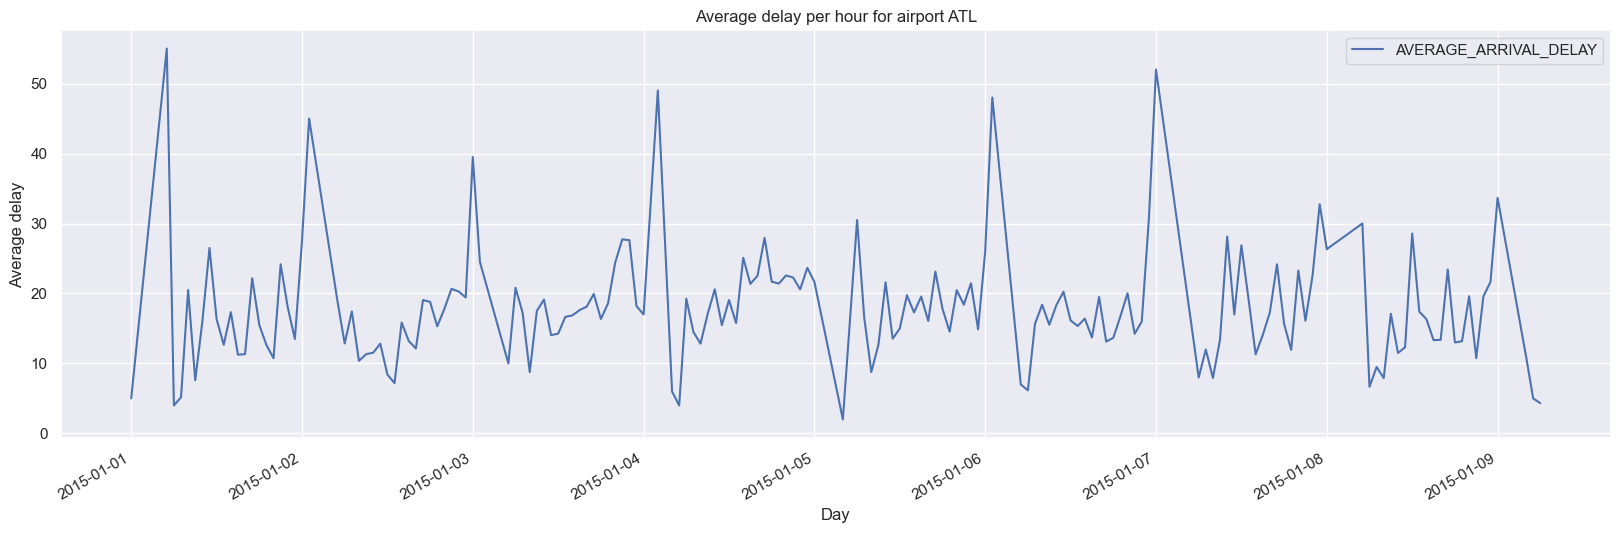

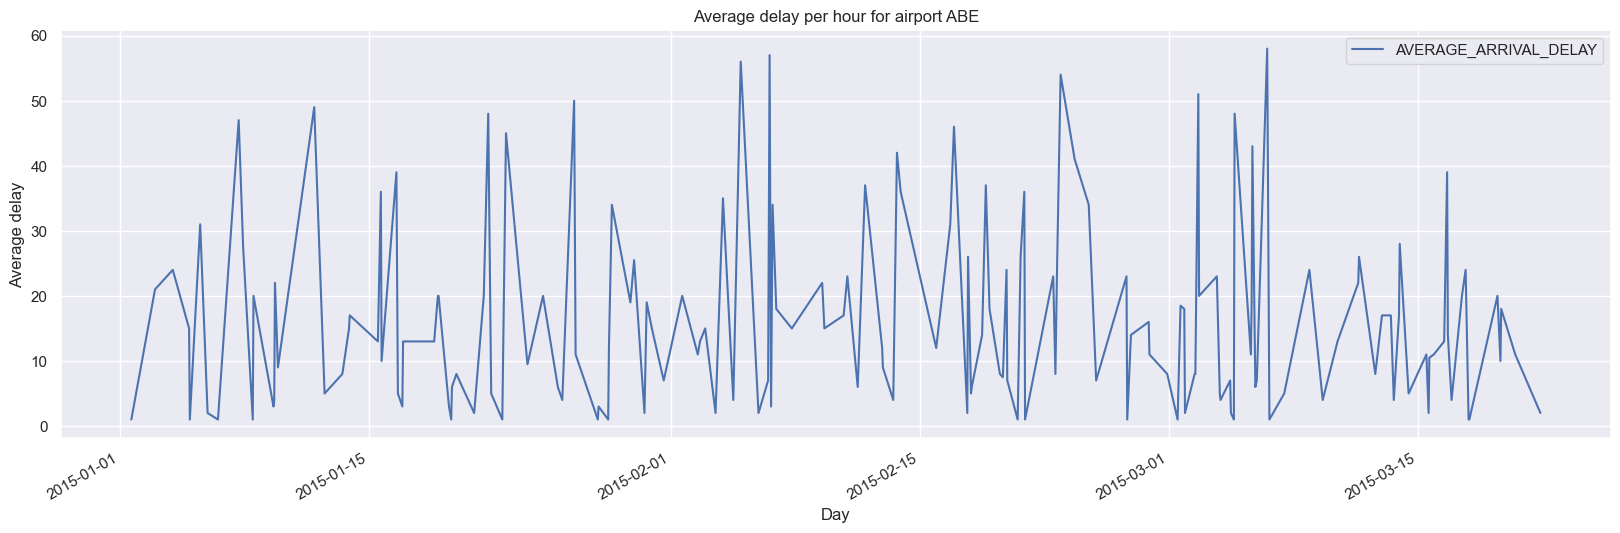

In [15]:
# plot avg_delay_per_hour per airport 

airports = ["ATL", "ABE"]
number_hours_week = 24 * 7 # 1 week

# Step 1: Convert ARRIVAL_DATE_TIME to datetime
df['ARRIVAL_DATE_TIME'] = pd.to_datetime(df_flights['ARRIVAL_DATE_TIME'])

# Step 2: Group by DESTINATION_AIRPORT and the hour of ARRIVAL_DATE_TIME, then calculate the mean ARRIVAL_DELAY
avg_delay_per_hour = df.groupby(['DESTINATION_AIRPORT', df['ARRIVAL_DATE_TIME'].dt.floor('H')])['ARRIVAL_DELAY'].mean().reset_index(name='AVERAGE_ARRIVAL_DELAY')

# Step 3: Optional - Reset the index if you want a clean DataFrame
avg_delay_per_hour = avg_delay_per_hour.reset_index(drop=True)

for airport in airports:
    avg_delay_per_hour[avg_delay_per_hour['DESTINATION_AIRPORT'] == airport][0:number_hours_week].plot(x='ARRIVAL_DATE_TIME', y='AVERAGE_ARRIVAL_DELAY')
    plt.xlabel('Day')
    plt.ylabel('Average delay')
    plt.title(f'Average delay per hour for airport {airport}')

The plots illustrate that certain airports might have daily activity patterns, while others do not.

## 2.1 Predicting delays: simple model

In [16]:
# take only 1st month
df_flights_january = df_flights[df_flights["ARRIVAL_DATE_TIME"] < datetime(2015, 2, 1)]
mod = smf.ols(formula='ARRIVAL_DELAY ~ C(DESTINATION_AIRPORT) + C(AIRLINE)', data=df_flights_january)

In [17]:
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          ARRIVAL_DELAY   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     8.637
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:04:26   Log-Likelihood:            -6.3264e+05
No. Observations:              154615   AIC:                         1.266e+06
Df Residuals:                  154291   BIC:                         1.269e+06
Df Model:                         323                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

The model is a simple linear regression model.
This model gives very poor results. This motivates us to use a more complex model.

## 2.2 Predicting delays: temporal graph neural network model

Due to the nature of the data, where we have relationships between airports, and relationship in the time, a conveniant way to model this is to use a temporal graph neural network.

This requires two steps:
- creation of the graph
- creation of the model and training

### 2.2.a Creation of the graph

In [18]:
# sort by index 
df_flights.sort_index(inplace=True)
print(df_flights.shape)
df_flights.head()

(1636290, 7)


,ORIGIN_AIRPORT,DESTINATION_AIRPORT,ARRIVAL_DELAY,AIRLINE,DISTANCE,YEAR,ARRIVAL_DATE_TIME
2,278,66,5.00,11,2296,2015,2015-01-01 08:11:00
5,278,216,8.00,3,1589,2015,2015-01-01 06:10:00
14,277,216,8.00,3,1399,2015,2015-01-01 05:57:00
20,174,192,6.00,8,1139,2015,2015-01-01 05:43:00
21,277,203,1.00,0,2724,2015,2015-01-01 09:39:00


In [19]:
# Prepare the Dataset to create the graph

# add 'AIRLINE' to the columns to get a second level => allows to predict delays also depending on airline
# => adds too much sparcity to the matrix
df_flights_new = df_flights.pivot_table(index='ARRIVAL_DATE_TIME', columns=['ORIGIN_AIRPORT'], values='ARRIVAL_DELAY')

In [20]:
# in-build model to fill missing values
df_flights_new = temporal_mean(df_flights_new)

# count how many non nan values we have
prop_nan_val = df_flights_new.count().sum().sum() / (df_flights_new.shape[0] * df_flights_new.shape[1])
print(f"Proportion of non nan values: {prop_nan_val}")

/Users/teframartin/Informatik/Swisscom/.conda/lib/python3.11/site-packages/tsl/ops/framearray.py:181: FutureWarning: The provided callable <function nanmean at 0x1140ac9a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  nan_mean = df_mean.groupby(conditions[0]).transform(np.nanmean)
/Users/teframartin/Informatik/Swisscom/.conda/lib/python3.11/site-packages/tsl/ops/framearray.py:181: FutureWarning: The provided callable <function nanmean at 0x1140ac9a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  nan_mean = df_mean.groupby(conditions[0]).transform(np.nanmean)
/Users/teframartin/Informatik/Swisscom/.conda/lib/python3.11/site-packages/tsl/ops/framearray.py:181: FutureWarning: The provided callable <function nanmean at 0x1140ac9a0>

Proportion of non nan values: 1.0


In [21]:
# create a dataset
target = df_flights_new.values
index = df_flights_new.index
mask = ~df_flights_new.isna().values
mask = torch.tensor(mask, dtype=torch.bool).unsqueeze(-1)

number_of_airports = len(df_flights.DESTINATION_AIRPORT.unique())
possible_trips = df_flights[["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]].drop_duplicates()
connectivity = (np.int64(possible_trips.values.T), np.ones(possible_trips.shape[0]))

In [22]:
torch_dataset = SpatioTemporalDataset(target=df_flights_new,
                                        connectivity=connectivity,
                                        mask= mask,
                                        horizon=1,
                                        window=12,
                                        stride=1)
                                      
print(torch_dataset)

SpatioTemporalDataset(n_samples=372110, n_nodes=322, n_channels=1)


We now have a ready to use graph.

### 2.2.b Creation of the model and training

In [23]:
# Normalize data using mean and std computed over time and node dimensions
scalers = {'target': StandardScaler(axis=(0, 1))}

# Split data
splitter = TemporalSplitter(val_len=0.1, test_len=0.2)

dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=splitter,
    batch_size=64,
    workers=7 
)

dm.setup()
print(dm)

SpatioTemporalDataModule(train_len=267908, val_len=29756, test_len=74422, scalers=[target], batch_size=64)


In [24]:
hidden_size = 32   #@param
rnn_layers = 1     #@param
gnn_kernel = 2     #@param

input_size = torch_dataset.n_channels   # 1 channel
n_nodes = torch_dataset.n_nodes         # 207 nodes
horizon = torch_dataset.horizon         # 12 time steps

stgnn = TimeThenSpaceModel(input_size=input_size,
                           n_nodes=n_nodes,
                           horizon=horizon,
                           hidden_size=hidden_size,
                           rnn_layers=rnn_layers,
                           gnn_kernel=gnn_kernel)
print(stgnn)
print_model_size(stgnn)

TimeThenSpaceModel(
  (encoder): Linear(in_features=1, out_features=32, bias=True)
  (node_embeddings): NodeEmbedding(n_nodes=322, embedding_size=32)
  (time_nn): RNN(
    (rnn): GRU(32, 32)
  )
  (space_nn): DiffConv(32, 32)
  (decoder): Linear(in_features=32, out_features=1, bias=True)
  (rearrange): Rearrange('b n (t f) -> b t n f', t=1)
)
Number of model (TimeThenSpaceModel) parameters:     21889


In [25]:
loss_fn = MaskedMAE()

metrics = {'mae': MaskedMAE(),
           'mape': MaskedMAPE(),
           'mae_at_15': MaskedMAE(at=2),  # '2' indicates the third time step,
                                          # which correspond to 15 minutes ahead
           'mae_at_30': MaskedMAE(at=5),
           'mae_at_60': MaskedMAE(at=11)}

# setup predictor
predictor = Predictor(
    model=stgnn,  
    optim_class=torch.optim.Adam,
    optim_kwargs={'lr': 0.001},
    loss_fn=loss_fn,
    metrics=metrics
)

In [26]:
logger = TensorBoardLogger(save_dir="logs", name="tsl_intro", version=0)

checkpoint_callback = ModelCheckpoint(
    dirpath='logs',
    save_top_k=1,
    monitor='val_mae',
    mode='min',
)

trainer = pl.Trainer(max_epochs=1,
                     logger=logger,
                    accelerator="cpu",
                     limit_train_batches=100,  # end an epoch after 100 updates
                     callbacks=[checkpoint_callback])

trainer.fit(predictor, datamodule=dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/teframartin/Informatik/Swisscom/.conda/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/teframartin/Informatik/Swisscom/.conda/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/teframartin/Informatik/Swisscom/logs exists and is not empty.

  | Name          | Type               | Params
-----------------------------------------------------
0 | loss_fn       | MaskedMAE          | 0     
1 | train_metrics | MetricCollection   | 0     
2 | val_metrics   | MetricCollection   | 0     
3 | test_metrics  | MetricCollection   | 0     
4 | model         | TimeThenSpaceModel | 21.9 K
-----------------------------------------------------
21.9 K    Trainable params
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/teframartin/Informatik/Swisscom/.conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

Only args ['x', 'edge_index', 'edge_weight'] are forwarded to the model (TimeThenSpaceModel). 


/Users/teframartin/Informatik/Swisscom/.conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 100/100 [01:43<00:00,  0.96it/s, v_num=0, val_mae=0.640, val_mae_at_15=0.000, val_mae_at_30=0.000, val_mae_at_60=0.000, val_mape=0.0908, train_mae=2.660, train_mae_at_15=0.000, train_mae_at_30=0.000, train_mae_at_60=0.000, train_mape=0.282]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 100/100 [01:43<00:00,  0.96it/s, v_num=0, val_mae=0.640, val_mae_at_15=0.000, val_mae_at_30=0.000, val_mae_at_60=0.000, val_mape=0.0908, train_mae=2.660, train_mae_at_15=0.000, train_mae_at_30=0.000, train_mae_at_60=0.000, train_mape=0.282]


In [27]:
predictor.load_model(checkpoint_callback.best_model_path)
predictor.freeze()

trainer.test(predictor, datamodule=dm)

Predictor with already instantiated model is loading a state_dict from /Users/teframartin/Informatik/Swisscom/logs/epoch=0-step=100-v14.ckpt. Cannot  check if model hyperparameters are the same.


## 3. Plotting some results

In [242]:
# constants
number_of_min_per_day = 24 * 60
number_of_days = 7

airport = 34 # can be change to any airport number
airport_name = df_airports['IATA_CODE'][airport]
print(f"Airport: {airport_name}")

Airport: BJI


In [218]:
# let's plot some predictions

data_arr = []
for i in range(number_of_days):
    data = dm.test_dataloader().dataset[i*number_of_min_per_day: (i+1)*number_of_min_per_day]
    data_arr.append(data)
predictor = Predictor(model=stgnn)

In [219]:
# create predictions
predictions_arr = []
iteration = 0
for data in data_arr:
    print(f"iteration {iteration}")
    # predict
    prediction = predictor.predict(data.input.x, data.input.edge_index, data.input.edge_weight)
    # descale predictions
    prediction = dm.scalers['target'].inverse_transform(prediction)   
    predictions_arr.append(prediction)
    iteration += 1

Only args [] are forwarded to the model (TimeThenSpaceModel). 


iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6


In [220]:
# regroup predictions and targets
predictions = torch.cat(predictions_arr, dim=0)
targets = [data.target.y for data in data_arr]
targets = torch.cat(targets, dim=0)

print(predictions.shape, targets.shape)

torch.Size([10080, 1, 322, 1]) torch.Size([10080, 1, 322, 1])


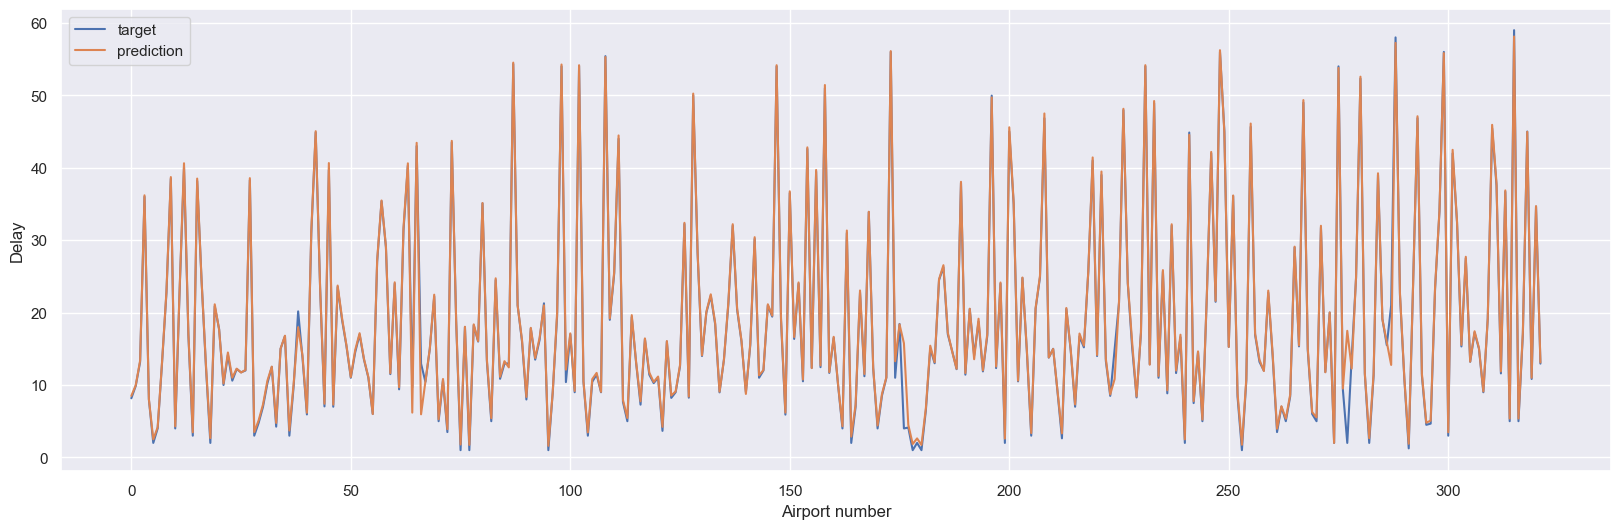

In [221]:
timestamp = 0 # 1st timestamp

plt.plot(targets[timestamp, 0, :, :].numpy(), label='target')
plt.plot(predictions[timestamp, 0, :, :].numpy(), label='prediction')
plt.xlabel('Airport number')
plt.ylabel('Delay')
plt.legend()
plt.show()

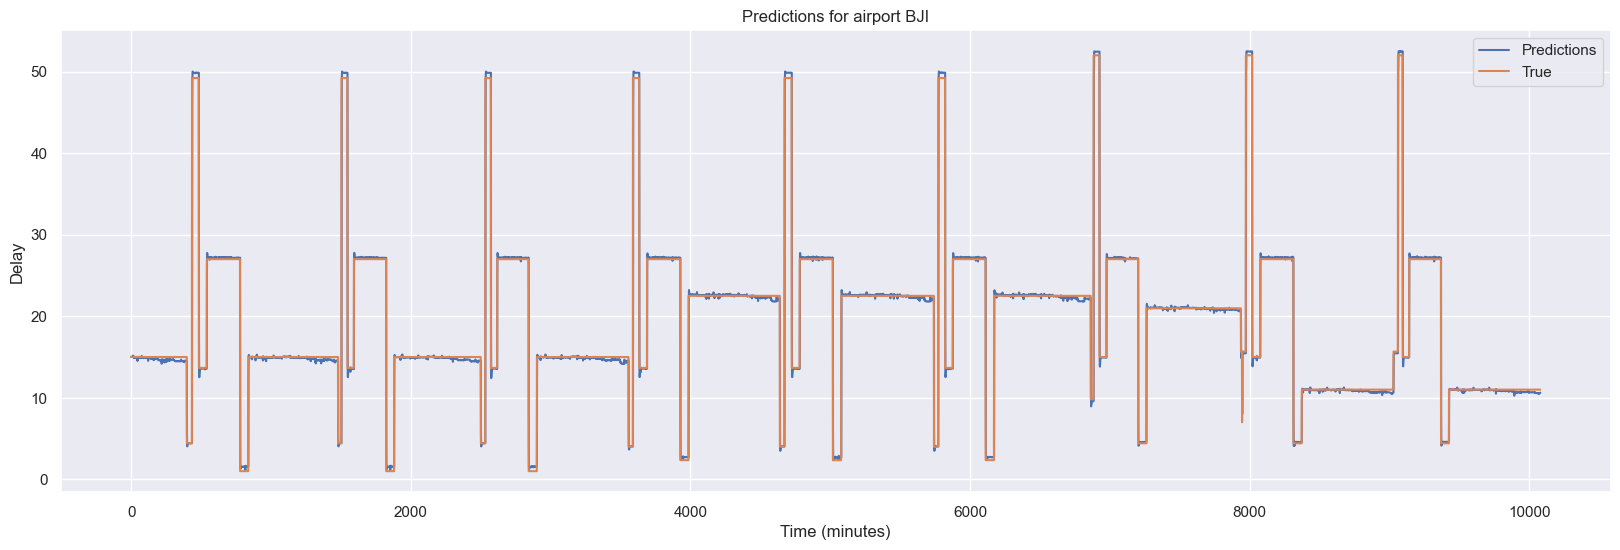

In [237]:
plt.plot(predictions[:, 0, airport, 0], label='Predictions')
plt.plot(targets[:, 0, airport, 0], label='True')
plt.legend()
plt.xlabel('Time (minutes)')
plt.ylabel('Delay')
plt.title(f'Predictions for airport {airport_name} over {number_of_days} days')
plt.show()

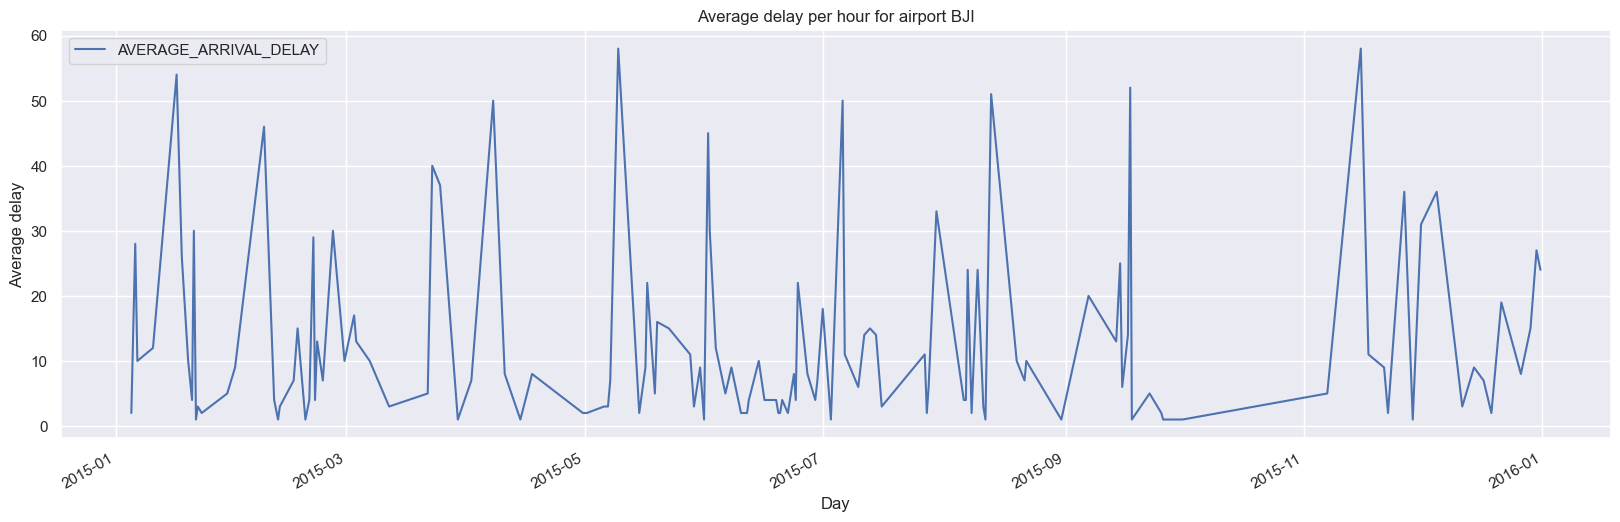

In [238]:
# lets plot the true data to compare
avg_delay_per_hour[avg_delay_per_hour['DESTINATION_AIRPORT'] == airport_name][0:24*7].plot(x='ARRIVAL_DATE_TIME', y='AVERAGE_ARRIVAL_DELAY')
plt.xlabel('Day')
plt.ylabel('Average delay')
plt.title(f'Average delay per hour for airport {airport_name}')
plt.show()

The model can predict very well the delays from the data.
We obeserve nevertheless a gap between the prediction and the real data in the plotting. Those plateau effect are due to the way we handle nan values.
Below we compute the cosine similarity.

In [250]:
# compute cosine similarity between prediction and real data from avg_delay_per_hour when it is not nan
from sklearn.metrics.pairwise import cosine_similarity

# we get the data
avg_delay_airport = avg_delay_per_hour[avg_delay_per_hour['DESTINATION_AIRPORT'] == airport_name]
avg_delay_airport = avg_delay_airport.set_index('ARRIVAL_DATE_TIME')
predictions_airport = predictions[:, 0, airport, 0]
predictions_airport = pd.DataFrame(predictions_airport.numpy(), index=index[:number_of_days * number_of_min_per_day])

# and then we merge the two dataframes
merged = pd.merge(avg_delay_airport, predictions_airport, left_index=True, right_index=True, how='inner')
merged = merged.dropna()

# finally we compute cosine similarity on this timeframe
cos_sim = cosine_similarity([merged['AVERAGE_ARRIVAL_DELAY']], [merged[0]])[0][0]
print(f"Cosine similarity between predictions and real data for airport {airport_name} over the first {number_of_days} days is:\n{cos_sim}")

Cosine similarity between predictions and real data for airport BJI over the first 7 days is:
0.9468229087801964


## 4. Conclusion

We managed to create 2 models to predict flight delays. 
The first one, the simple model, gave poor results, showing the complexity of the relationship between the features and the delays.
The second model, the temporal graph model, gave high accuracy. Nevertheless, we failed to predict the delays depeding on both airports and the airlines. Indeed this was creating too much sparcity in our data and the model was not able to learn from it. Dealing with that would be the next step to improve the model.